# Introduction

The following notebook contains an exploratory data analysis of a dataset containing several aspects of houses. I also used supervised machine learning models to predict house prices. The dataset is from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/), which uses RMSE (root-mean-squared-error) as a metric, which is why it is also used in this notebook. My RMSE score based on the test dataset is 0.14163, using Ridge Regression.

# Loading the Data

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 300)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [573]:
# Loading preprocessed data
df_train_pre = pd.read_csv('train.csv')
df_test_pre = pd.read_csv('test.csv')

In [574]:
# Columns of dataset
test_set_id = pd.Series(data=df_test_pre.Id)
df_test_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [575]:
print(df_train_pre.shape)
print(df_test_pre.shape)

(1460, 81)
(1459, 80)


All numerical information is int or float, so there is no need to convert numerical variables.

In [576]:
df_train_pre.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [577]:
df_test_pre.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


# Data Preprocessing

## Missing Values

### Visualizing missing values

In [578]:
# Concatonating train and test sets
df = pd.concat([df_train_pre, df_test_pre], axis=0)

# Removing Id column
df.drop('Id',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [579]:
# Displaying columns that have missing values, excluding "SalePrice"
null = df.iloc[:,:-1].isnull().sum().sort_values(ascending = False).reset_index().rename(columns={'index':'column',0:'sum_of_null'})
columns_with_missing = null[null['sum_of_null'] != 0]
columns_with_missing

,column,sum_of_null
0,PoolQC,2909
1,MiscFeature,2814
2,Alley,2721
3,Fence,2348
4,FireplaceQu,1420
5,LotFrontage,486
6,GarageCond,159
7,GarageQual,159
8,GarageYrBlt,159
9,GarageFinish,159


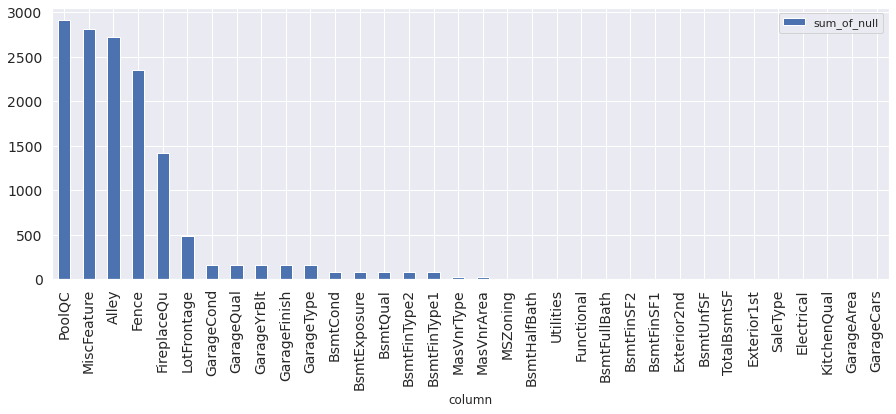

In [580]:
# Visualizing the number of missing values from columns
columns_with_missing.plot(kind='bar',x='column', y='sum_of_null', figsize=(15,5), fontsize=14)

### Imputing missing values

I fill the missing values in PoolQC with 'None', because the feature refers to the quality of pools, if the house has a pool. Only some houses seem to have a pool, but those that do not, should have their own class: None.
The MiscFeature refers to miscellaneous features that are not covered in other categories according to the data description: NA = None.

In [581]:
df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] =df["MiscFeature"].fillna("None")

In case of the "Alley" and "Fence" features, a missing value refers to having no alley access or no fence.

In [582]:
df["Alley"] = df["Alley"].fillna("None") 
df["Fence"] = df["Fence"].fillna("None")

The FireplaceQU feature refers to the quality of the fireplace, which only few houses have. The other houses should be "None", since they don't have a fireplace. 

In [583]:
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

According to the data description, the LotFrontage feature is the linear feet of street connected ot the property. So I will impute the missing values with the median value of its neighbourhood. I chose the median because it is less sensitive to outliers than the mean.

In [584]:
lotfr_median = df.groupby("Neighborhood")["LotFrontage"].median()
lotfr_median

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    65.0
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [585]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

The features GarageType, GarageFinish, GarageQual, and GarageCond refer to garages so they are only valid when the house has a garage. The rest of the houses should have "None".
Similarly, the BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 features refer to basements.
MasVnrType means Masonry veneer type.

In [586]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            'MasVnrType'):
    df[col] = df[col].fillna('None')

GarageYrBlt, GarageArea and GarageCars also refer to garages, when the house has one. I will replace the missing values with 0, since these are numerical variables.
Similarly, the BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath features refer to basements when there is one. Missing values = 0.
MasVnrArea is masonry veneer area in square feet, so the missing values probably do not have a masonry.

In [587]:
for col in ('GarageYrBlt', 'GarageArea',
            'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    df[col] = df[col].fillna(0)

MSZoning refers to the general zoning classification of the sale. I will replace the missing values with the most commonly occuring category.


In [588]:
df['MSZoning'].value_counts()
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0]) 

The Utilities feature is almost entirely made up of the 'AllPub' class and has two missing values.

In [589]:
df['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

The only value "NoSeWa" is in the training dataset, because the first 1460 values in the dataframe are from the training dataset. So we can safely drop this feature.

In [590]:
# Index of the "NoSeWa" value: 944
df.index[df['Utilities'] == "NoSeWa"]

# Deleting the Utilities feature
df = df.drop(['Utilities'], axis=1)

The feature Functional refers to home functionality. The missing values are to be considered the class "typical" according to the data description. It has two missing values, which will be replaced with "Typ".

In [591]:
df['Functional'].value_counts()
df['Functional'] = df['Functional'].fillna('Typ')

The Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType features' missing values will be replaced with the most common values.

In [592]:
for i in ('Electrical', 'KitchenQual', 'Exterior1st', 
            'Exterior2nd', 'SaleType'):
    df[i] = df[i].fillna(df[i].mode()[0])

After checking missing values once more, we can see that there are no more missing values.

In [593]:
# Displaying columns that have missing values excluding "SalePrice"
null = df.iloc[:,:-1].isnull().sum().sort_values(ascending = False).reset_index().rename(columns={'index':'column',0:'sum_of_null'})
null[null.sum_of_null !=0]

,column,sum_of_null


In [594]:
# Separating the dataset
df_train = df[:len(df_train_pre)]
df_test = df[len(df_train_pre):]

## Visualising the target variable: SalePrice

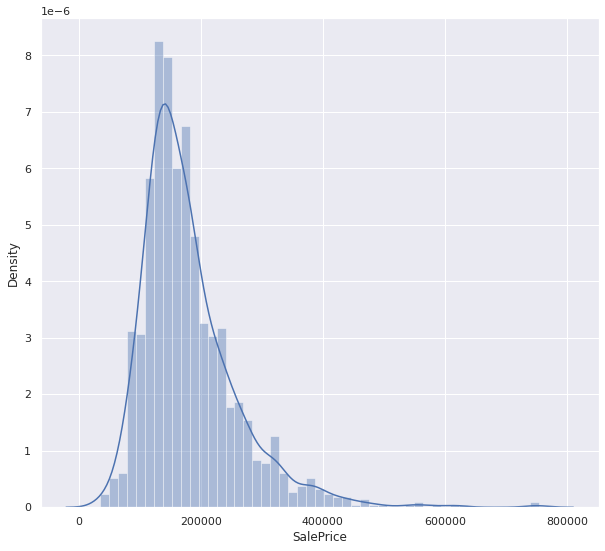

In [595]:
sns.set()
plt.figure(figsize = (10,9))
sns.distplot(a = df_train['SalePrice'])
plt.grid(True)

Skewness refers to a distortion or asymmetry that deviates from the normal distribution. 0 skewness means that the distributin is normal. Positive skeweness means that the right tail of the distribution is longer. Kurtosis is a measure of the "tailedness", i.e. how heavily the tails of the distribution differ from the tails of a normal distribution. It is a measure of extreme values in the distribution. As we can see, the SalePrice variable has a right skew with a significant kurtosis.

In [596]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


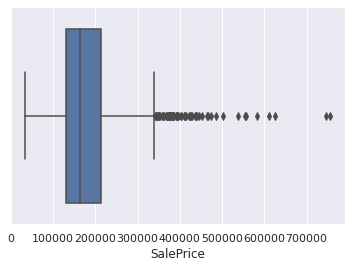

In [597]:
# Boxplot of SalePrice
sns.set_theme()
sns.boxplot(df_train['SalePrice'])

## Feature Correlations

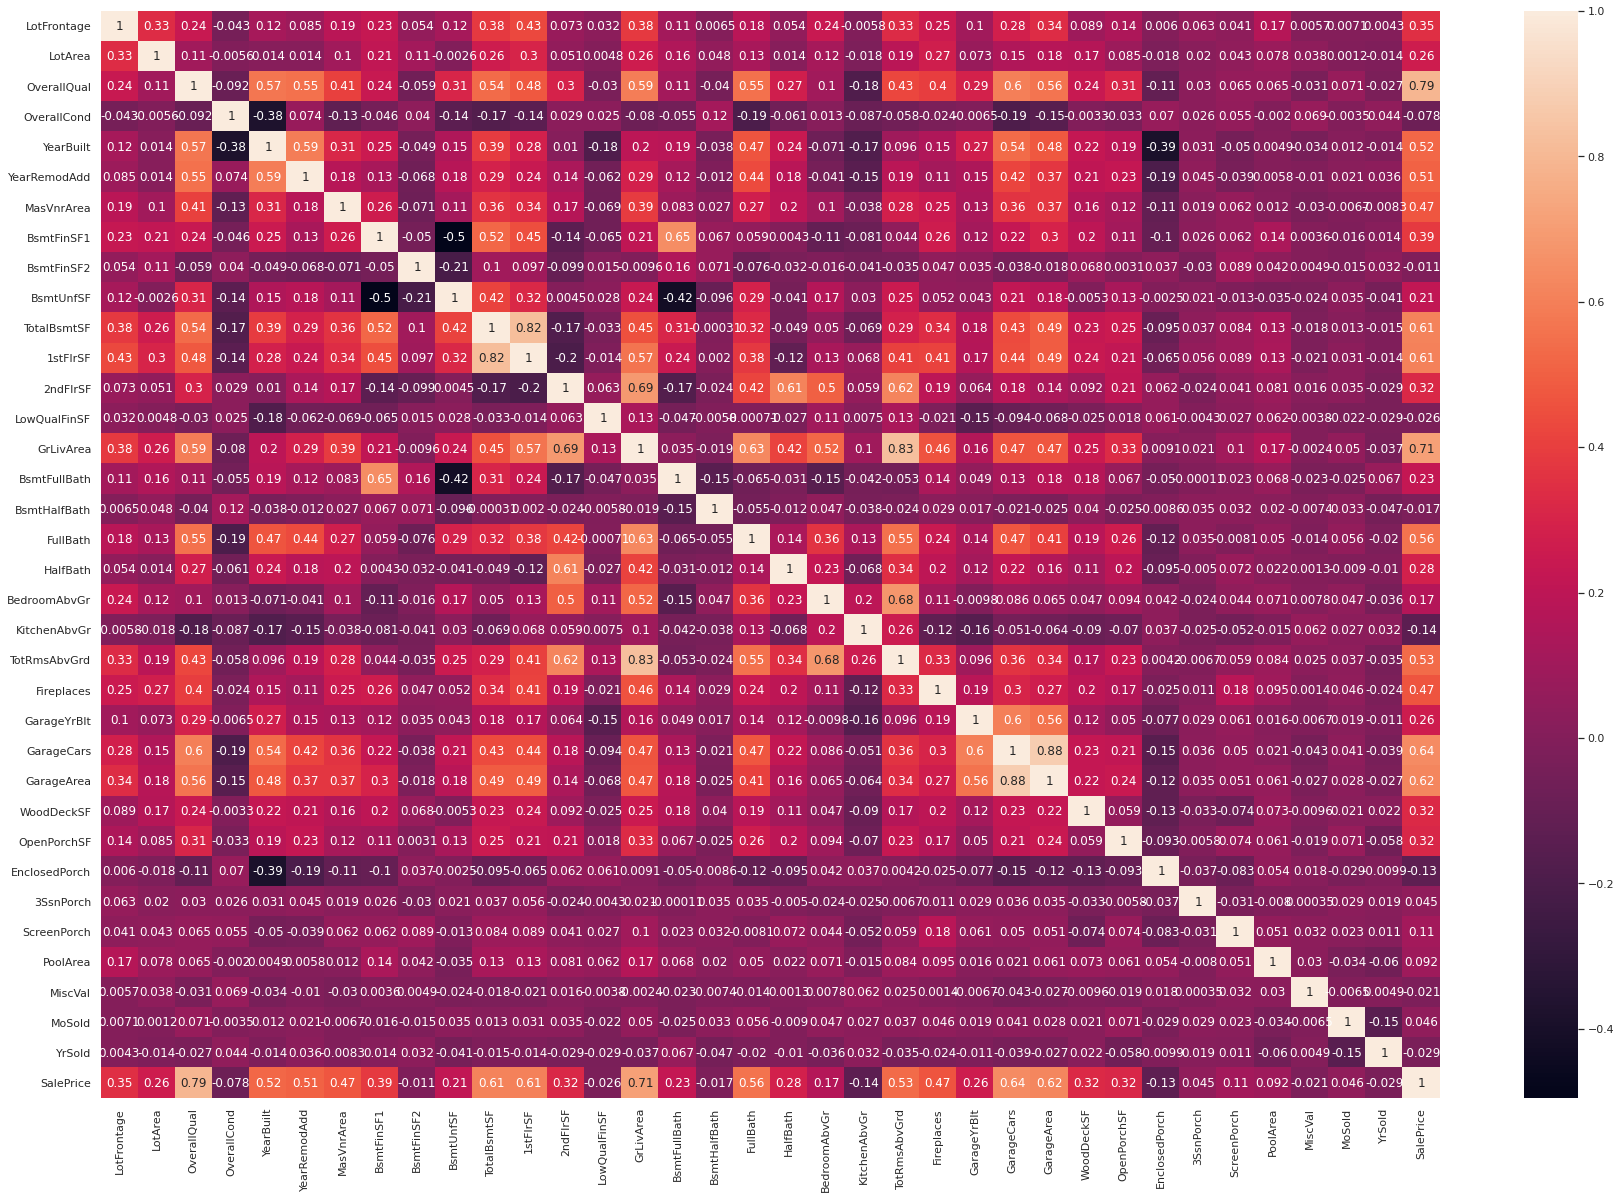

In [598]:
# Pairwise correlation of features
corr_matr = df_train.iloc[:,1:].corr()
plt.subplots(figsize = (30,20))
sns.heatmap(corr_matr, annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


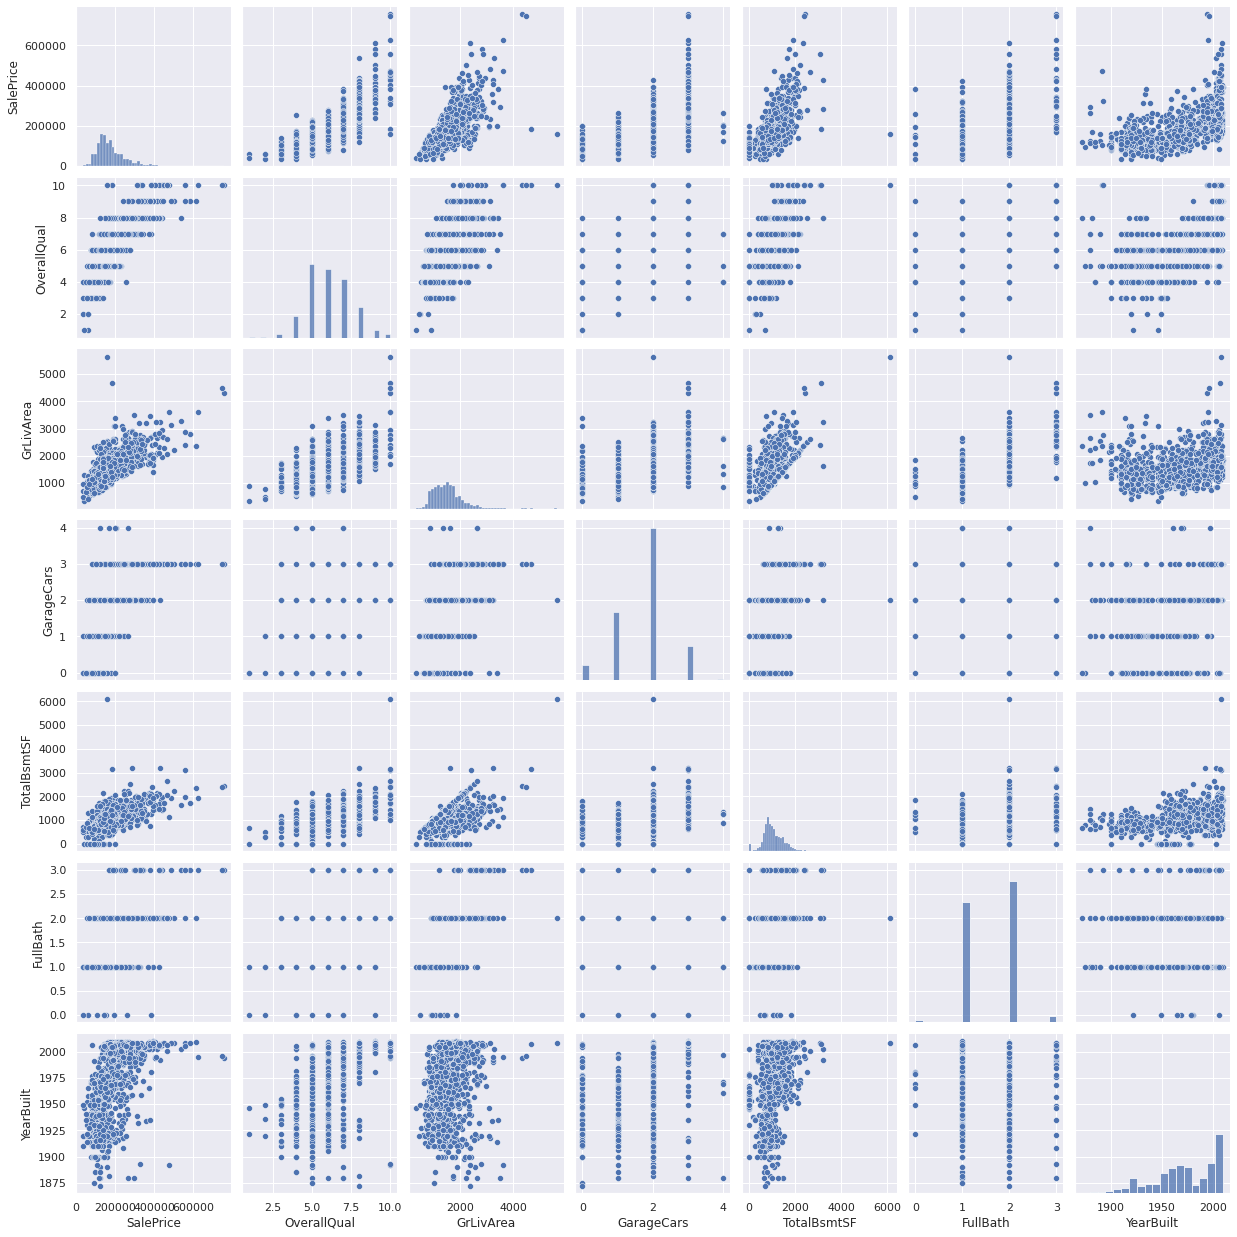

In [599]:
# Plotting some feature correlations
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

**Plotting some higher correlations**

OverallQual has the highest positive correlation with SalePrice.

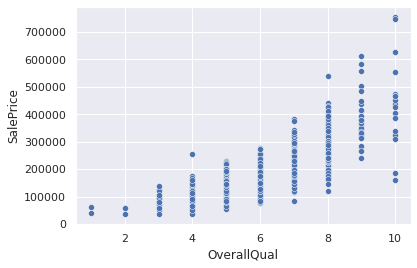

In [600]:
sns.scatterplot(x=df_train.OverallQual, y=df_train.SalePrice)

The second highest correlation is between GrLiveArea and SalePrice. As we can see, the tendency is that the higher the living area, the higher the price, although there are some outliers as well. A similar positive correlation can be found between the following variables.

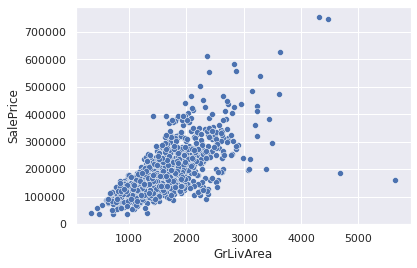

In [601]:
sns.scatterplot(x=df_train.GrLivArea, y=df_train.SalePrice)

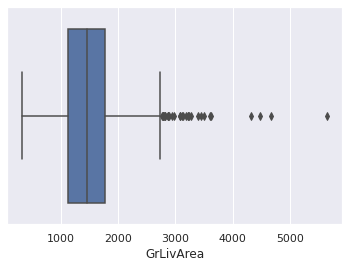

In [602]:
# There are some noticeable outliers in the data:
sns.boxplot(df_train.GrLivArea)

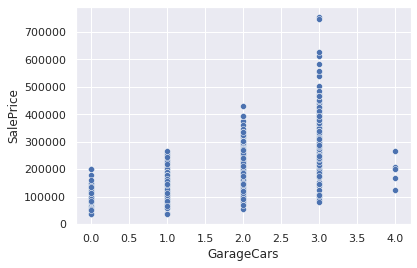

In [603]:
sns.scatterplot(x=df_train.GarageCars, y=df_train.SalePrice)

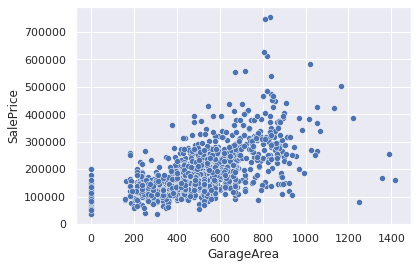

In [604]:
sns.scatterplot(x=df_train.GarageArea, y=df_train.SalePrice)

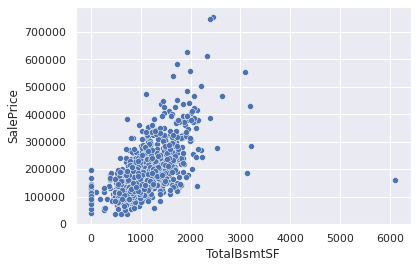

In [605]:
sns.scatterplot(x=df_train.TotalBsmtSF, y=df_train.SalePrice)

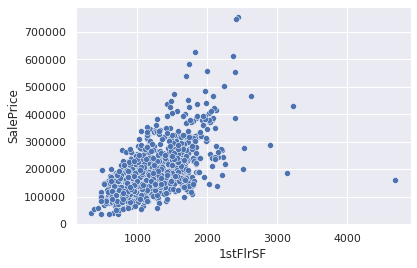

In [606]:
sns.scatterplot(x=df_train['1stFlrSF'], y=df_train.SalePrice)

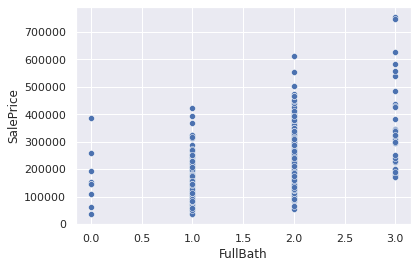

In [607]:
sns.scatterplot(x=df_train.FullBath, y=df_train.SalePrice)

## Removing outliers

In [608]:
# Removing outliers based on GrLivArea
from scipy import stats
df_train = df_train[(np.abs(stats.zscore(df_train.GrLivArea)) < 3)]

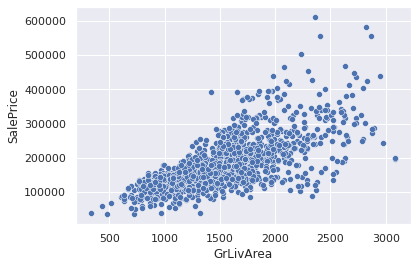

In [609]:
# GrLivArea vs. SalePrie after removing some outliers
sns.scatterplot(x=df_train.GrLivArea, y=df_train.SalePrice)

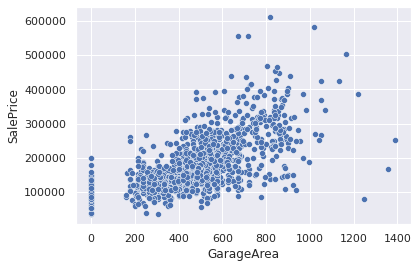

In [610]:
sns.scatterplot(x=df_train.GarageArea, y=df_train.SalePrice)

## Log transformation

In [611]:
# Tansforming target variable to handle skewness
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

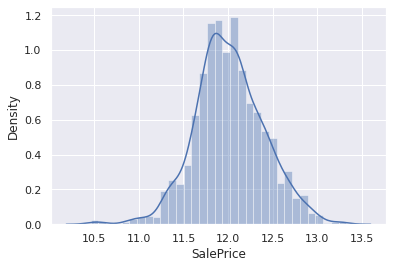

In [612]:
## Plotting the transformed dependent variable
sns.distplot(a = df_train['SalePrice'])

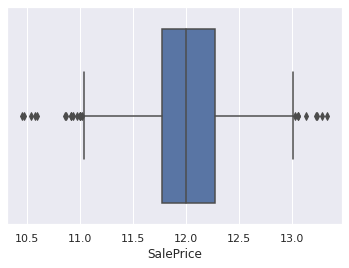

In [613]:
sns.boxplot(df_train['SalePrice'])

In [614]:
df['GrLivArea'] = np.log(df['GrLivArea'])

## Converting some features into categorical features

Similarly, the following features are  converted into categorical features because they are categorical in nature but are coded as numerical features.

In [615]:
df = pd.concat([df_train, df_test], axis=0)

In [616]:
df['MSSubClass'] = df['MSSubClass'].astype(object)
df['OverallQual'] = df['OverallQual'].astype(object)
df['OverallCond'] = df['OverallCond'].astype(object)

## Feature Engineering

**Creating new features**

In [617]:
df['TotalSF'] = (df['TotalBsmtSF'] 
                       + df['1stFlrSF'] 
                       + df['2ndFlrSF'])                             

df['Total_Bathrooms'] = (df['FullBath'] 
                               + (0.5 * df['HalfBath']) 
                               + df['BsmtFullBath'] 
                               + (0.5 * df['BsmtHalfBath']))
                              
                               
df['Total_porch_sf'] = (df['OpenPorchSF'] 
                              + df['3SsnPorch'] 
                              + df['EnclosedPorch'] 
                              + df['ScreenPorch'] 
                              + df['WoodDeckSF'])

df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
                           

**Numerical Features**

In [618]:
# Separating the names of categorical and numerical features
df_num = df.dtypes[df.dtypes != "object"].index
df_cat = df.dtypes[df.dtypes == "object"].index

In [619]:
# Correlations with SalePrice (absolute values)
df_corr = df[:1444].corr().abs()
corr_target = df_corr.SalePrice.sort_values(ascending=False)
corr_target

SalePrice          1.000000
TotalSF            0.817968
GrLivArea          0.710349
GarageCars         0.678574
Total_Bathrooms    0.665242
GarageArea         0.654039
TotalBsmtSF        0.638897
YearBuilt          0.611488
1stFlrSF           0.603286
FullBath           0.578334
YearRemodAdd       0.571107
TotRmsAbvGrd       0.516244
Fireplaces         0.479489
MasVnrArea         0.413758
Total_porch_sf     0.385212
BsmtFinSF1         0.381867
GarageYrBlt        0.357454
LotFrontage        0.357007
hasgarage          0.331019
OpenPorchSF        0.329351
WoodDeckSF         0.320069
HalfBath           0.307244
2ndFlrSF           0.280364
LotArea            0.244988
BsmtFullBath       0.240763
BsmtUnfSF          0.215318
BedroomAbvGr       0.186332
EnclosedPorch      0.164657
KitchenAbvGr       0.149823
ScreenPorch        0.112068
LowQualFinSF       0.075427
MoSold             0.067564
3SsnPorch          0.059296
YrSold             0.036555
PoolArea           0.036214
MiscVal            0

In [620]:
# Features above a correlation of 0.4 will be kept, below that, they will be dropped
feat_num_keep = list(corr_target[corr_target.values > 0.3].index)
feat_num_drop = list(corr_target[corr_target.values <= 0.3].index)

In [621]:
print('Numerical features to keep:',feat_num_keep,'\n')
print('Numerical features to drop:',feat_num_drop)

Numerical features to keep: ['SalePrice', 'TotalSF', 'GrLivArea', 'GarageCars', 'Total_Bathrooms', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF', 'FullBath', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'Total_porch_sf', 'BsmtFinSF1', 'GarageYrBlt', 'LotFrontage', 'hasgarage', 'OpenPorchSF', 'WoodDeckSF', 'HalfBath'] 

Numerical features to drop: ['2ndFlrSF', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'LowQualFinSF', 'MoSold', '3SsnPorch', 'YrSold', 'PoolArea', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


**Categorical Features**

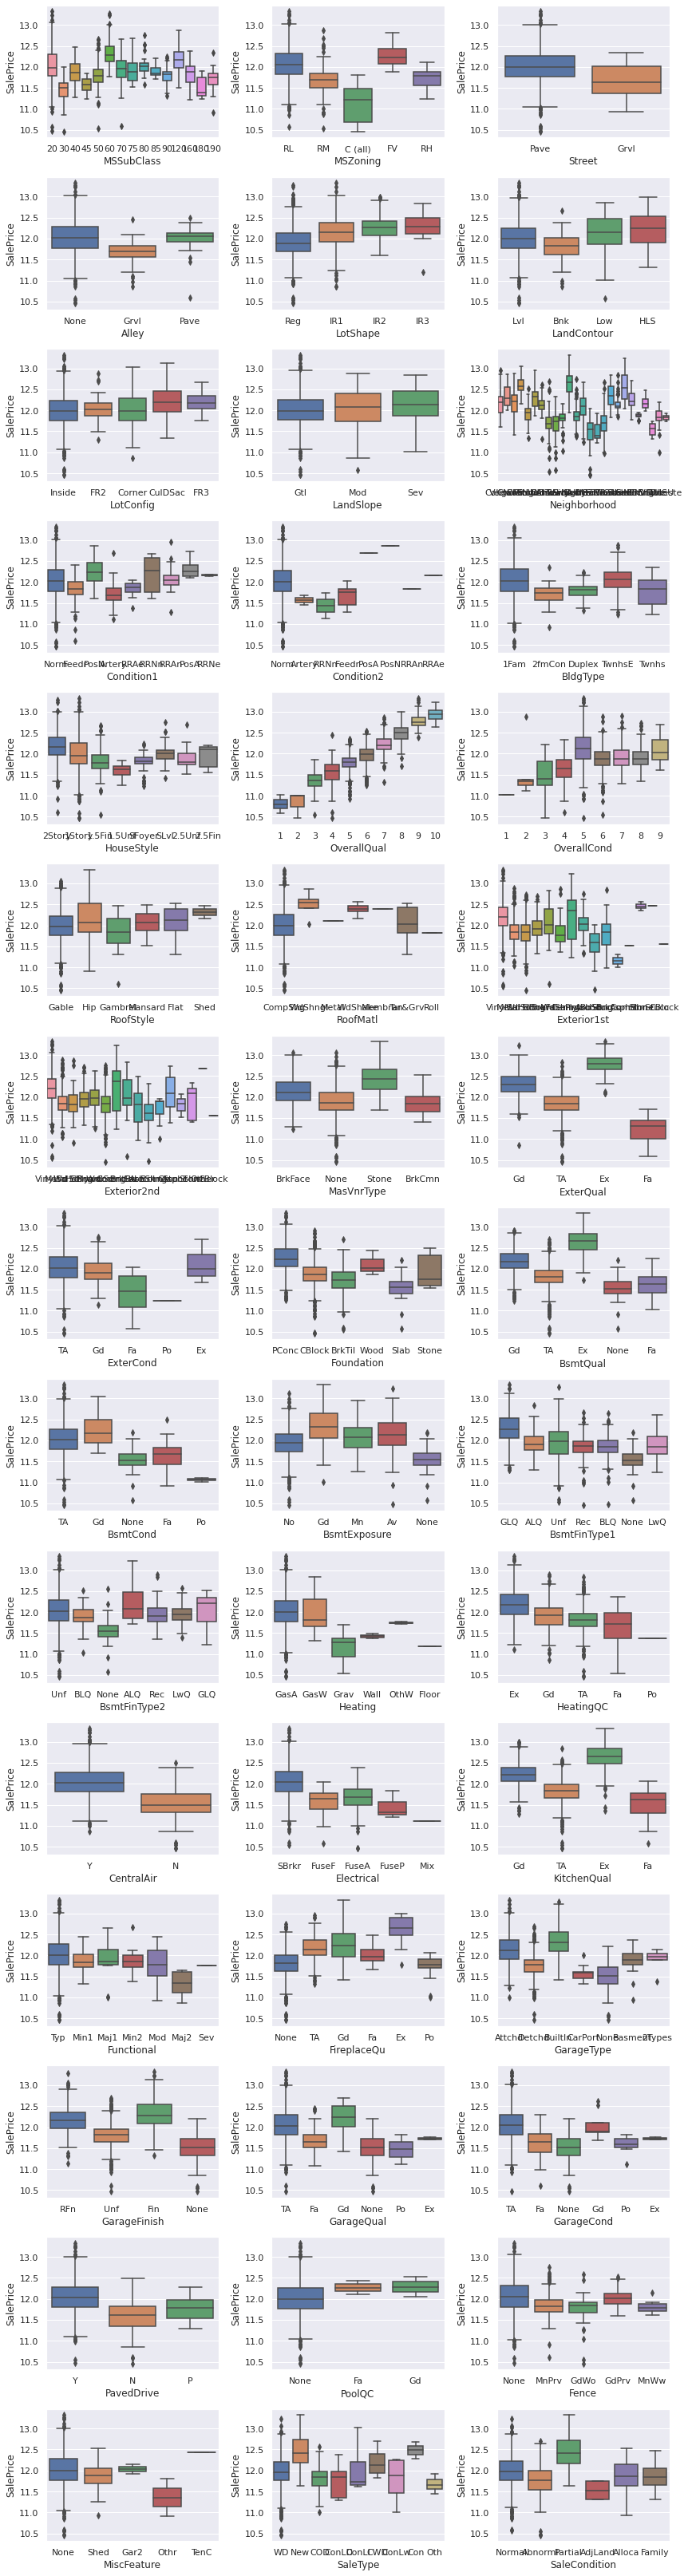

In [622]:
# Plotting relationship between categorical features
cat_feats = list(df_cat)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(cat_feats):
            sns.boxplot(x=cat_feats[i], y='SalePrice', data=df[:len(df_train)], ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

In [623]:
# Select categorical features to drop
feat_cat_drop = ['Street', 'LotShape', 'LandContour', 'LotConfig', 
          'LandSlope',  'BldgType', 'RoofStyle', 
          'Foundation', 'GarageType', 'Exterior2nd',
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
          'HeatingQC',   'GarageFinish', 'Condition1', 'Functional',
          'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
          'SaleCondition']


In [624]:
# Dropping some numerical and categorical features
feat_drop = feat_cat_drop + feat_num_drop 
df.drop(feat_drop, inplace= True, axis = 1)

In [625]:
obj_columns = df.select_dtypes(include=[object])
obj_columns.columns.values

array(['MSSubClass', 'MSZoning', 'Alley', 'Neighborhood', 'Condition2',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofMatl',
       'Exterior1st', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual',
       'FireplaceQu', 'MiscFeature', 'SaleType'], dtype=object)

In [626]:
df.shape

(2903, 44)

**Creating dummy variables**

In [627]:
df_dummies = pd.get_dummies(df)
df_dummies.shape

(2903, 188)

## Creating dependent and independent variables



In [628]:
# Separating the processed dataset into train and test sets
df_train_dummies = df_dummies[:len(df_train)]
df_test_dummies = df_dummies[len(df_train):]

In [629]:
df_train_dummies.tail()

,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,TotalSF,Total_Bathrooms,Total_porch_sf,hasgarage,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,...,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1455,62.0,1999,2000,0.0,0.0,953.0,953,1647,2,1,7,1,1999.0,2.0,460.0,0,40,12.072547,2600.0,2.5,40,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1456,85.0,1978,1988,119.0,790.0,1542.0,2073,2073,2,0,7,2,1978.0,2.0,500.0,349,0,12.254868,3615.0,3.0,349,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1457,66.0,1941,2006,0.0,275.0,1152.0,1188,2340,2,0,9,2,1941.0,1.0,252.0,0,60,12.493133,3492.0,2.0,60,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1458,68.0,1950,1996,0.0,49.0,1078.0,1078,1078,1,0,5,0,1950.0,1.0,240.0,366,0,11.864469,2156.0,2.0,478,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1459,75.0,1965,1965,0.0,830.0,1256.0,1256,1256,1,1,6,0,1965.0,1.0,276.0,736,68,11.901590,2512.0,2.5,804,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [630]:
# Separating train and test sets into features and target variable
X = df_train_dummies.drop('SalePrice', axis = 1)
y = df_train_dummies["SalePrice"]

test_set_X = df_test_dummies.drop('SalePrice', axis = 1)

In [631]:
# Separating training data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 25)

**Create scaled data**

In [632]:
# Create standard scaler
df_dummies_scaled = df_dummies.copy()
scaler = StandardScaler()

# Scaling numerical columns
df_dummies_scaled[['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF',
       'Total_Bathrooms', 'Total_porch_sf']] = scaler.fit_transform(df_dummies_scaled[[
       'LotFrontage','YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF',
       'Total_Bathrooms', 'Total_porch_sf']])


In [633]:
df_dummies_scaled.head(3)

,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,TotalSF,Total_Bathrooms,Total_porch_sf,hasgarage,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,...,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-0.205152,1.048658,0.899285,0.552863,0.608950,-0.445693,-0.782265,0.463386,0.799523,1.236735,1.021850,-0.922119,0.295042,0.313812,0.359213,-0.738223,0.205553,12.247699,0.047265,1.608459,-0.759940,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.507748,0.154341,-0.391447,-0.571441,1.224514,0.508449,0.283870,-0.474589,0.799523,-0.753421,-0.278361,0.635130,0.234966,0.313812,-0.052080,1.626854,-0.703444,12.109016,-0.008051,0.361135,0.732097,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.062572,0.982412,0.851481,0.357830,0.111067,-0.295287,-0.614204,0.622507,0.799523,1.236735,-0.278361,0.635130,0.290592,0.313812,0.639639,-0.738223,-0.077578,12.317171,0.231653,1.608459,-0.879555,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [634]:
# Separating the scaled dataset into train and test sets
df_train_dummies_scaled = df_dummies_scaled[:len(df_train)]
df_test_dummies_scaled = df_dummies_scaled[len(df_train):]

In [635]:
# Separating scaled train and test sets into features and target variable
X_scaled = df_train_dummies_scaled.drop('SalePrice', axis = 1)
y_scaled = df_train_dummies_scaled['SalePrice']

test_set_X_scaled = df_test_dummies_scaled.drop('SalePrice', axis = 1)

In [636]:
# Separating scaled training data into train and test sets
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled,y_scaled, test_size = 0.3, random_state = 25)

# Model Building

In [637]:
# Set the metric and cross validation
metric = 'neg_mean_squared_error'
cv_num = 5

# Function to get best RMSE from cross validated grid search
def best_results(grid):
    best_rmse = np.sqrt(-grid.best_score_)
    print(grid.best_params_)
    # print(grid.best_estimator_)
    print("\nBest score: ",best_rmse)
    return best_rmse

## Multiple Linear Regression

In [638]:
lr = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(lr, parameters, cv=cv_num, verbose=1 , scoring=metric)
best_lr = grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


In [639]:
score_lr = best_results(grid_lr)

{'fit_intercept': True, 'normalize': False}

Best score:  0.13014401599415204


## Ridge Regression

In [640]:
ridge = Ridge()
param_ridge = {'alpha':[1e-4, 1e-3,1e-2,0.5,1,1.5, 2], 'normalize':[True, False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, param_ridge, cv=cv_num, verbose=1, scoring=metric)
best_ridge = grid_ridge.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    4.8s finished


In [641]:
score_ridge = best_results(grid_ridge)

{'alpha': 2, 'normalize': False, 'tol': 1e-06}

Best score:  0.11783354105682069


In [642]:
y_pred_ridge = grid_ridge.predict(test_set_X)

## Lasso Regression

In [643]:
lasso = Lasso()
param_lasso = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True, False]}
grid_lasso = GridSearchCV(lasso, parameters, cv=cv_num, verbose=1, scoring=metric)
best_lasso = grid_lasso.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


In [644]:
score_lasso = best_results(grid_lasso)

{'fit_intercept': True, 'normalize': False}

Best score:  0.17097928280677385


## Elastic Net

In [645]:
elnet = ElasticNet()
param_elnet = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_elnet = GridSearchCV(elnet, param_elnet, cv=cv_num, verbose=1, scoring=metric)
best_elnet = grid_elnet.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   17.3s finished


In [646]:
score_elnet = best_results(grid_elnet)

{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.0001}

Best score:  0.1479739773394755


## Decision Tree Regressor


In [647]:
dt = DecisionTreeRegressor()
param_dt = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
            
grid_dt = GridSearchCV(dt, param_dt, cv=cv_num, refit=True, verbose=1, scoring=metric)
best_dt = grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   15.0s finished


In [648]:
score_dt = best_results(grid_dt)

{'max_depth': 9, 'max_features': 14, 'max_leaf_nodes': None, 'min_samples_split': 30, 'presort': False, 'random_state': 5}

Best score:  0.20486812151592868


## Random Forest Regressor

In [649]:
rf = RandomForestRegressor()
param_rf = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(rf, param_rf, cv=cv_num, refit=True, verbose=1, scoring=metric)
best_rf = grid_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   37.9s finished


In [650]:
score_rf = best_results(grid_rf)

{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}

Best score:  0.1458548912549428


## KNN Regressor

In [651]:
knn = KNeighborsRegressor()
param_knn = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(knn, param_knn, cv=cv_num, refit=True, verbose=1, scoring=metric)
best_knn = grid_knn.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   10.8s finished


In [652]:
score_knn = best_results(grid_knn)

{'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'distance'}

Best score:  0.15647103042653318


## Ensemble Approach

In [653]:
best_lr = best_lr.best_estimator_
best_ridge = best_ridge.best_estimator_
best_lasso = best_lasso.best_estimator_
best_elnet = best_elnet.best_estimator_
best_dt = best_dt.best_estimator_
best_rf = best_rf.best_estimator_
best_knn = best_knn.best_estimator_

In [654]:
voting_reg1 = VotingRegressor(estimators = [('ridge',best_ridge),('lr',best_lr)])
voting_reg2 = VotingRegressor(estimators = [('ridge',best_ridge),('lr',best_lr),('rf',best_rf)]) 
voting_reg3 = VotingRegressor(estimators = [('ridge',best_ridge),('lr',best_lr),('rf',best_rf),('elnet', best_elnet)])

In [655]:
# Function to get evaluation metric (RMSE) of voting regressor
def get_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=metric, cv=cv_num).mean())
    return (rmse)

score_voting = get_rmse(voting_reg2)

print('RMSE voting regressor 1:',get_rmse(voting_reg1))
print('RMSE voting regressor 2:',get_rmse(voting_reg2))
print('RMSE voting regressor 3:',get_rmse(voting_reg3))

RMSE voting regressor 1: 0.12196175972371254
RMSE voting regressor 2: 0.11874524190612026
RMSE voting regressor 3: 0.1207533748834287


## Summary

In [657]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'KNN', 'Ridge', 'Lasso', 'Elastic Net',
              'Decision Tree', 'Random Forest','Voting Regressor'],
    'Score': [score_lr, score_knn, score_ridge, score_lasso, 
              score_elnet, score_dt, score_rf, score_voting]})
models.sort_values(by='Score', ascending=True)

,Model,Score
2,Ridge,0.117834
7,Voting Regressor,0.118745
0,Linear Regression,0.130144
6,Random Forest,0.145855
4,Elastic Net,0.147974
1,KNN,0.156471
3,Lasso,0.170979
5,Decision Tree,0.204868


Creating submission file

In [658]:
# Calculate the exponential of the target variable
# y_pred = np.exp(y_pred_ridge) 

# Create submission file
# sub = pd.DataFrame()
# sub['Id'] = test_set_id
# sub['SalePrice'] = y_pred
# sub.to_csv('results.csv',index=False)